# Predict the Loan Defaulter for Lending Club data using Industry Segmentation and Sentiment Analysis - Removing Collection Fee Variable

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Read the data and perform the necessary pre processing

In [2]:
import pandas as pd
import numpy as np
data_reduced=pd.read_csv("final_data_v3.csv")

## Split X and Y, remove varibales with correlation > 0.6 and Collection Fee Removed

In [3]:
X=data_reduced.drop(['loan_status'],axis=1)
y=data_reduced[['loan_status']]

In [4]:
correlation_matrix=X.corr()

In [5]:
# Filter the correlation matrix to show only values greater than 0.6
filtered_corr = correlation_matrix.where(correlation_matrix > 0.6, np.nan)

# Set the diagonal values to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns where all elements are NaN
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Melt the DataFrame to show only the non-NaN values
filtered_corr_melted = filtered_corr.stack().reset_index()
filtered_corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']

print(filtered_corr_melted)

              Variable 1            Variable 2  Correlation
0            installment       total_rec_prncp     0.765573
1            delinq_2yrs    num_tl_90g_dpd_24m     0.667981
2                pub_rec  pub_rec_bankruptcies     0.609783
3                pub_rec             tax_liens     0.739624
4              revol_bal      total_rev_hi_lim     0.813389
5              total_acc             num_il_tl     0.695882
6              total_acc         num_rev_accts     0.740337
7              total_acc              num_sats     0.697688
8        total_rec_prncp           installment     0.765573
9        total_rec_prncp       last_pymnt_amnt     0.659399
10       last_pymnt_amnt       total_rec_prncp     0.659399
11  last_fico_range_high   last_fico_range_low     0.841422
12   last_fico_range_low  last_fico_range_high     0.841422
13        acc_now_delinq          num_tl_30dpd     0.820706
14      total_rev_hi_lim             revol_bal     0.813389
15      total_rev_hi_lim        total_bc

In [6]:
col_2_drop=filtered_corr_melted['Variable 2'].unique()

In [7]:
col_2_drop=list(col_2_drop)

In [8]:
X_mod=X.drop(col_2_drop,axis=1)
X_mod=X_mod.drop('collection_recovery_fee',axis=1)

## With Sentiment and Industry Segmentation

### Train, Test Split With Sentiment Columns

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 113), y_train shape: (116984, 1)
X_test shape: (29247, 113), y_test shape: (29247, 1)


### Implementing Smote for Class imbalance¶

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


In [13]:
import warnings
warnings.filterwarnings("ignore")
models = []
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('KNN', KNeighborsClassifier( )))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('NB',GaussianNB()))
models.append(('XGB', XGBClassifier(random_state=42)))


### Building Machine Learning Model

#### Basic Model

In [14]:
for name, model in models:
    #model_name, _ = model
    model.fit(X_train_smote, y_train_smote)
    y_pred_train = model.predict(X_train_smote)
    y_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy_test}")

LR Train Accuracy: 0.7347945750224995
LR Test Accuracy: 0.7371012411529387
KNN Train Accuracy: 0.866091797651688
KNN Test Accuracy: 0.6452969535336958
CART Train Accuracy: 1.0
CART Test Accuracy: 0.7663692002598557
RF Train Accuracy: 1.0
RF Test Accuracy: 0.8477792594112217
NB Train Accuracy: 0.6484124824713786
NB Test Accuracy: 0.8127329298731494
XGB Train Accuracy: 0.9190962556771803
XGB Test Accuracy: 0.8542414606626321


#### Hyper parameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
warnings.filterwarnings("ignore")

# List of models and their hyperparameters to tune
models = []
models.append(('LR', LogisticRegression(random_state=42), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}))
models.append(('KNN', KNeighborsClassifier(), {'n_neighbors': np.arange(5, 35, 5), 'weights': ['uniform', 'distance']}))
models.append(('CART', DecisionTreeClassifier(random_state=42), {'max_depth': np.arange(5, 25, 5), 'min_samples_split': np.arange(5, 25, 5)}))
models.append(('RF', RandomForestClassifier(random_state=42), {'n_estimators': np.arange(5, 25, 5), 'max_features': ['auto', 'sqrt', 'log2']}))
models.append(('NB', GaussianNB(), {}))  # GaussianNB doesn't have hyperparameters to tune
models.append(('XGB', XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}))


# Iterate over each model, perform hyperparameter tuning, and evaluate
for name, model, params in models:
    if params:
        grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # If there are no hyperparameters to tune
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
        best_params = "N/A"
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the best model on the full training data
    best_model.fit(X_train_smote, y_train_smote)
    y_pred = best_model.predict(X_test)
    
    # Calculate classification metrics
    report = classification_report(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC-AUC score if the model supports predict_proba
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = "N/A"
    
    print(f"{name} Classification Report:")
    print(report)
    print(f"Cross-Validation ROC-AUC Score: {mean_cv_score} ± {std_cv_score}")
    print(f"Test ROC-AUC Score: {roc_auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Model Params{best_params}")
    print()
    with open(f'{name}_best_model_WTS_60_CF.pkl', 'wb') as file:
        pickle.dump(best_model, file)

LR Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.70      0.49      5338
           1       0.92      0.75      0.82     23909

    accuracy                           0.74     29247
   macro avg       0.65      0.72      0.66     29247
weighted avg       0.82      0.74      0.76     29247

Cross-Validation ROC-AUC Score: 0.8159705689002044 ± 0.007228261378098357
Test ROC-AUC Score: 0.8031062804466186
Confusion Matrix:
[[ 3719  1619]
 [ 6070 17839]]
Model Params{'C': 100, 'solver': 'lbfgs'}

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.70      0.41      5338
           1       0.90      0.62      0.73     23909

    accuracy                           0.63     29247
   macro avg       0.60      0.66      0.57     29247
weighted avg       0.79      0.63      0.68     29247

Cross-Validation ROC-AUC Score: 0.9426157082390892 ± 0.012788310641829611
Test ROC-AUC S

### Build Deep Learning

In [22]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[113]),
keras.layers.Dense(1000, activation="relu"),
keras.layers.Dense(450, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1, activation="sigmoid")
])

In [23]:
train_data = X_train_smote
val_data = X_test
train_labels_mc = y_train_smote
val_labels_mc = y_test

In [24]:
# Since it is binary class classification binary crossentropy and accuracy as metric is utilized to compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
optimizer=opt,
metrics=["accuracy"])

In [25]:
history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)# Turn verbose=1 to printing epochs

Epoch 1/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7318 - loss: 0.5386 - val_accuracy: 0.7630 - val_loss: 0.4711
Epoch 2/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.7633 - loss: 0.4840 - val_accuracy: 0.7494 - val_loss: 0.5002
Epoch 3/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7734 - loss: 0.4641 - val_accuracy: 0.7539 - val_loss: 0.5017
Epoch 4/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7583 - loss: 0.4911 - val_accuracy: 0.6847 - val_loss: 0.5625
Epoch 5/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7576 - loss: 0.4902 - val_accuracy: 0.7146 - val_loss: 0.5401
Epoch 6/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7612 - loss: 0.4892 - val_accuracy: 0.6790 - val_loss: 0.5369
Epoch 7/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7472 - loss: 0.5075 - val_accuracy: 0.7273 - val_loss: 0.5813
Epoch 8/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.7103 -

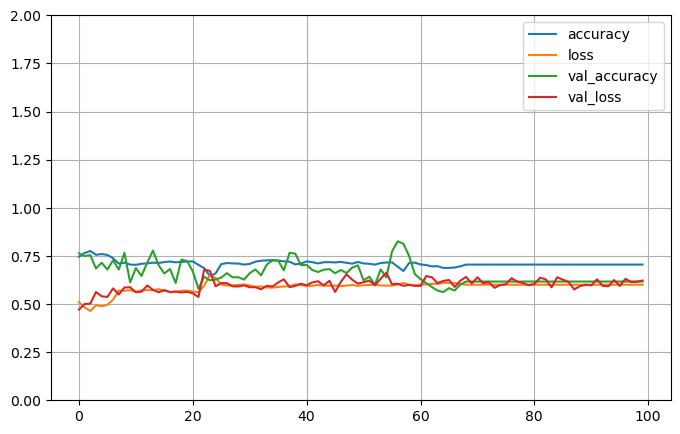

In [26]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import classification_report

# Train your model (already done)
#history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)

# Make predictions on the validation set
predictions = model.predict(val_data)

# Convert predictions to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Generate and print the classification report
report = classification_report(val_labels_mc, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)


914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.30      0.81      0.44      5338
     Class 1       0.93      0.57      0.71     23909

    accuracy                           0.62     29247
   macro avg       0.62      0.69      0.57     29247
weighted avg       0.82      0.62      0.66     29247



## Without Sentiment- Dropping Industry and Sentiment Analysis Column

In [28]:
col2=list(X_mod.filter(regex='Sentiment Score', axis=1).columns)
col2.append(list(X_mod.filter(regex='sector_', axis=1).columns))

In [29]:
col2=['Sentiment Score_2007',
 'Sentiment Score_2008',
 'Sentiment Score_2009',
 'Sentiment Score_2010',
 'Sentiment Score_2011',
 'Sentiment Score_2012',
 'Sentiment Score_2013',
 'Sentiment Score_2014',
 'Sentiment Score_2015',
 'Sentiment Score_2016',
 'Sentiment Score_2017',
 'Sentiment Score_2018','sector_Education',
  'sector_Finance and Banking',
  'sector_Healthcare',
  'sector_IT',
  'sector_Manufacturing']

### Remove Sentiment Columns

In [30]:
X_mod=X_mod.drop(col2,axis=1)

### Train, Test Split

In [31]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 96), y_train shape: (116984, 1)
X_test shape: (29247, 96), y_test shape: (29247, 1)


### Implementing Smote for Class Imbalance

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


In [33]:
import warnings
warnings.filterwarnings("ignore")
models = []
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('NB',GaussianNB()))
models.append(('XGB', XGBClassifier(random_state=42)))


### Build Machine Learning Model

#### Basic Model

In [34]:
for name, model in models:
    #model_name, _ = model
    model.fit(X_train_smote, y_train_smote)
    y_pred_train = model.predict(X_train_smote)
    y_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy_test}")

LR Train Accuracy: 0.7136765106008917
LR Test Accuracy: 0.7288268882278525
KNN Train Accuracy: 0.868074886456393
KNN Test Accuracy: 0.6477245529456013
CART Train Accuracy: 1.0
CART Test Accuracy: 0.7510855814271549
RF Train Accuracy: 1.0
RF Test Accuracy: 0.8375559886484084
NB Train Accuracy: 0.6340128508340485
NB Test Accuracy: 0.8178616610250624
XGB Train Accuracy: 0.9152504238263672
XGB Test Accuracy: 0.8485998563955277


#### Hyper Parameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
warnings.filterwarnings("ignore")

# List of models and their hyperparameters to tune
models = []
models.append(('LR', LogisticRegression(random_state=42), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}))
models.append(('KNN', KNeighborsClassifier(), {'n_neighbors': np.arange(5, 35, 5), 'weights': ['uniform', 'distance']}))
models.append(('CART', DecisionTreeClassifier(random_state=42), {'max_depth': np.arange(5, 25, 5), 'min_samples_split': np.arange(5, 25, 5)}))
models.append(('RF', RandomForestClassifier(random_state=42), {'n_estimators': np.arange(5, 25, 5), 'max_features': ['auto', 'sqrt', 'log2']}))
models.append(('NB', GaussianNB(), {}))  # GaussianNB doesn't have hyperparameters to tune
models.append(('XGB', XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}))


# Iterate over each model, perform hyperparameter tuning, and evaluate
for name, model, params in models:
    if params:
        grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # If there are no hyperparameters to tune
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
        best_params = "N/A"
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the best model on the full training data
    best_model.fit(X_train_smote, y_train_smote)
    y_pred = best_model.predict(X_test)
    
    # Calculate classification metrics
    report = classification_report(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC-AUC score if the model supports predict_proba
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = "N/A"
    
    print(f"{name} Classification Report:")
    print(report)
    print(f"Cross-Validation ROC-AUC Score: {mean_cv_score} ± {std_cv_score}")
    print(f"Test ROC-AUC Score: {roc_auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Model Params{best_params}")
    print()
    with open(f'{name}_best_model_WS_60_CF.pkl', 'wb') as file:
        pickle.dump(best_model, file)

LR Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.67      0.47      5338
           1       0.91      0.74      0.82     23909

    accuracy                           0.73     29247
   macro avg       0.64      0.71      0.65     29247
weighted avg       0.81      0.73      0.75     29247

Cross-Validation ROC-AUC Score: 0.7925908174392957 ± 0.006372218012622891
Test ROC-AUC Score: 0.7818257784319937
Confusion Matrix:
[[ 3583  1755]
 [ 6175 17734]]
Model Params{'C': 100, 'solver': 'lbfgs'}

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.66      0.40      5338
           1       0.89      0.63      0.74     23909

    accuracy                           0.64     29247
   macro avg       0.59      0.64      0.57     29247
weighted avg       0.78      0.64      0.68     29247

Cross-Validation ROC-AUC Score: 0.932679307418099 ± 0.009834507207227637
Test ROC-AUC Sc

### Deep Learning

In [42]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[96]),
keras.layers.Dense(1000, activation="relu"),
keras.layers.Dense(450, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1, activation="sigmoid")
])

In [43]:
train_data = X_train_smote
val_data = X_test

In [44]:
train_labels_mc = y_train_smote
val_labels_mc = y_test

In [45]:
# Since it is binary class classification binary crossentropy and accuracy as metric is utilized to compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
optimizer=opt,
metrics=["accuracy"])

In [46]:
history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)# Turn verbose=1 to printing epochs

Epoch 1/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7008 - loss: 0.5835 - val_accuracy: 0.7624 - val_loss: 0.5162
Epoch 2/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7254 - loss: 0.5360 - val_accuracy: 0.7464 - val_loss: 0.4950
Epoch 3/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7365 - loss: 0.5342 - val_accuracy: 0.6883 - val_loss: 0.5833
Epoch 4/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7513 - loss: 0.5089 - val_accuracy: 0.5676 - val_loss: 0.7152
Epoch 5/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7649 - loss: 0.4880 - val_accuracy: 0.7028 - val_loss: 0.5585
Epoch 6/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7753 - loss: 0.4675 - val_accuracy: 0.6953 - val_loss: 0.5756
Epoch 7/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7777 - loss: 0.4657 - val_accuracy: 0.7342 - val_loss: 0.5254
Epoch 8/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7728 -

In [47]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the validation set
predictions = model.predict(val_data)

# Convert predictions to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Generate and print the classification report
report = classification_report(val_labels_mc, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)


914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.43      0.45      0.44      5338
     Class 1       0.88      0.87      0.87     23909

    accuracy                           0.79     29247
   macro avg       0.65      0.66      0.66     29247
weighted avg       0.79      0.79      0.79     29247



## Statistical Test 

In [6]:
import pandas as pd
import numpy as np
data_reduced=pd.read_csv("final_data_v3.csv")
X=data_reduced.drop(['loan_status'],axis=1)
y=data_reduced[['loan_status']]

In [7]:
correlation_matrix=X.corr()

In [8]:
# Filter the correlation matrix to show only values greater than 0.6
filtered_corr = correlation_matrix.where(correlation_matrix > 0.6, np.nan)

# Set the diagonal values to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns where all elements are NaN
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Melt the DataFrame to show only the non-NaN values
filtered_corr_melted = filtered_corr.stack().reset_index()
filtered_corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']

print(filtered_corr_melted)

              Variable 1            Variable 2  Correlation
0            installment       total_rec_prncp     0.765573
1            delinq_2yrs    num_tl_90g_dpd_24m     0.667981
2                pub_rec  pub_rec_bankruptcies     0.609783
3                pub_rec             tax_liens     0.739624
4              revol_bal      total_rev_hi_lim     0.813389
5              total_acc             num_il_tl     0.695882
6              total_acc         num_rev_accts     0.740337
7              total_acc              num_sats     0.697688
8        total_rec_prncp           installment     0.765573
9        total_rec_prncp       last_pymnt_amnt     0.659399
10       last_pymnt_amnt       total_rec_prncp     0.659399
11  last_fico_range_high   last_fico_range_low     0.841422
12   last_fico_range_low  last_fico_range_high     0.841422
13        acc_now_delinq          num_tl_30dpd     0.820706
14      total_rev_hi_lim             revol_bal     0.813389
15      total_rev_hi_lim        total_bc

In [9]:
col_2_drop=filtered_corr_melted['Variable 2'].unique()
col_2_drop=list(col_2_drop)
X_mod=X.drop(col_2_drop,axis=1)
X_mod=X_mod.drop('collection_recovery_fee',axis=1)

### With Sentiment - Final XGB model with the best parameters and feature importance

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 113), y_train shape: (116984, 1)
X_test shape: (29247, 113), y_test shape: (29247, 1)


In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


Test Accuracy: 0.8569425924026396
Test Precision: 0.863514061405772
Test Recall: 0.9798820527834706
Test F1 Score: 0.9180250783699059
Test ROC AUC: 0.8266829481667257

Feature Importance:
                              Feature  Importance
106            debt_settlement_flag_N    0.447660
35                            grade_A    0.067894
0                            int_rate    0.036465
6                  total_rec_late_fee    0.029729
33                     term_36 months    0.021943
32               Sentiment Score_2018    0.021006
28               Sentiment Score_2014    0.018537
29               Sentiment Score_2015    0.017138
31               Sentiment Score_2017    0.013126
27               Sentiment Score_2013    0.011508
81                home_ownership_RENT    0.009284
30               Sentiment Score_2016    0.009217
78            home_ownership_MORTGAGE    0.008996
96             purpose_small_business    0.006463
82   verification_status_Not Verified    0.006394
15          

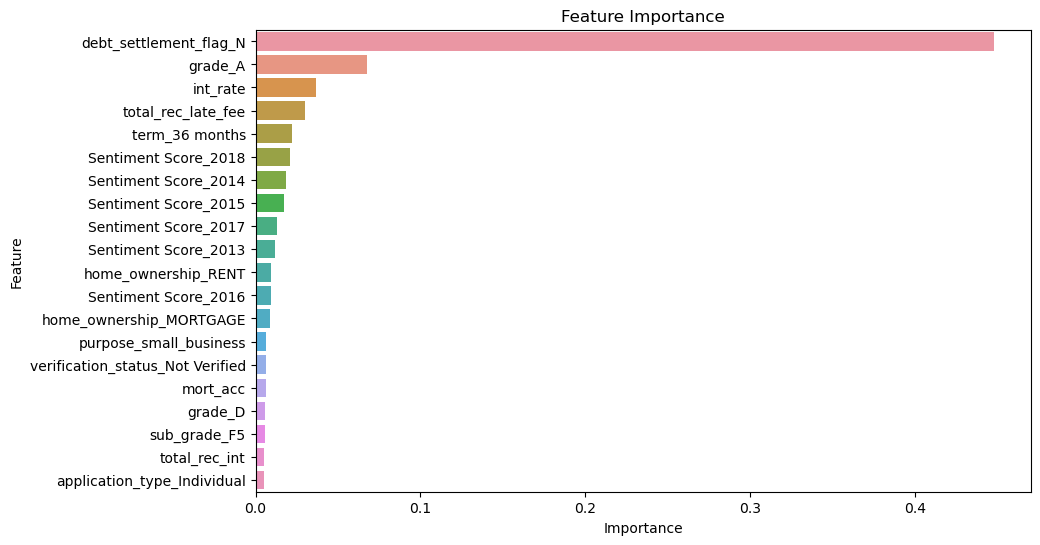

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

model_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200,'random_state': 42 }
model = XGBClassifier(**model_params)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on both the training and test data
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

# Calculate probabilities for ROC AUC
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics for the training data
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Calculate metrics for the test data
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

'''
# Print the metrics
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")
'''

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test ROC AUC: {roc_auc_test}")

# Get feature importance
feature_importances = model.feature_importances_
features = X_mod.columns 
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:20]

# Print feature importance
print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


### Without Sentiment - Final XGB model with the best parameters and feature importance

In [13]:
col2=['Sentiment Score_2007',
 'Sentiment Score_2008',
 'Sentiment Score_2009',
 'Sentiment Score_2010',
 'Sentiment Score_2011',
 'Sentiment Score_2012',
 'Sentiment Score_2013',
 'Sentiment Score_2014',
 'Sentiment Score_2015',
 'Sentiment Score_2016',
 'Sentiment Score_2017',
 'Sentiment Score_2018','sector_Education',
  'sector_Finance and Banking',
  'sector_Healthcare',
  'sector_IT',
  'sector_Manufacturing']

In [14]:
X_mod_no_senti=X_mod.drop(col2,axis=1)

# Split the data into train and test sets
X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_no_senti = scaler.fit_transform(X_train_no_senti)
X_test_no_senti = scaler.transform(X_test_no_senti)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train_no_senti.shape}, y_train shape: {y_train_no_senti.shape}")
print(f"X_test shape: {X_test_no_senti.shape}, y_test shape: {y_test_no_senti.shape}")

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_no_senti, y_train_no_senti = smote.fit_resample(X_train_no_senti, y_train_no_senti)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_no_senti)}")

X_train shape: (116984, 96), y_train shape: (116984, 1)
X_test shape: (29247, 96), y_test shape: (29247, 1)
SMOTE target distribution: Counter({'loan_status': 1})


Test Accuracy: 0.8496256026259104
Test Precision: 0.8577243225404275
Test Recall: 0.9783345183821992
Test F1 Score: 0.9140679953106683
Test ROC AUC: 0.7891447943754388

Feature Importance:
                                Feature  Importance
94               debt_settlement_flag_N    0.236599
22                       term_60 months    0.144894
4                        inq_last_6mths    0.069081
15                             mort_acc    0.055056
70     verification_status_Not Verified    0.047250
18                num_accts_ever_120_pd    0.046434
69                  home_ownership_RENT    0.032486
87                initial_list_status_f    0.027564
6                    total_rec_late_fee    0.027129
0                              int_rate    0.026523
14                       mo_sin_rcnt_tl    0.023777
88                initial_list_status_w    0.023750
3                       fico_range_high    0.021878
17                mths_since_recent_inq    0.018833
76           purpose_debt_conso

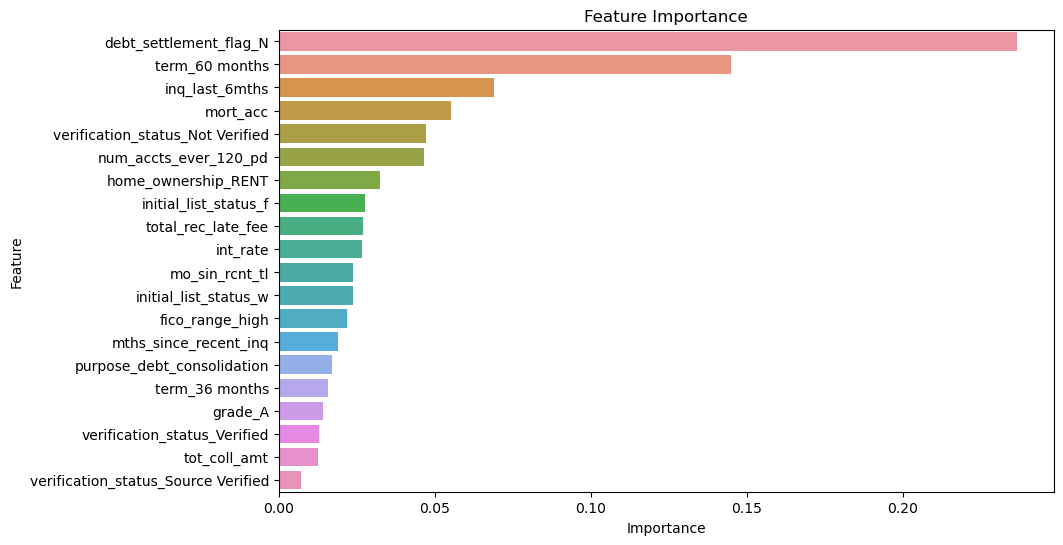

In [15]:

# Initialize the model with specified parameters
model_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200 , 'random_state': 42}
model1 = XGBClassifier(**model_params)

# Fit the model on the training data
model1.fit(X_train_no_senti, y_train_no_senti)

# Make predictions on both the training and test data
y_pred_train = model1.predict(X_train_no_senti)
y_pred = model1.predict(X_test_no_senti)

# Calculate probabilities for ROC AUC
y_pred_proba_train = model1.predict_proba(X_train_no_senti)[:, 1]
y_pred_proba = model1.predict_proba(X_test_no_senti)[:, 1]

# Calculate metrics for the training data
accuracy_train = accuracy_score(y_train_no_senti, y_pred_train)
precision_train = precision_score(y_train_no_senti, y_pred_train)
recall_train = recall_score(y_train_no_senti, y_pred_train)
f1_train = f1_score(y_train_no_senti, y_pred_train)
roc_auc_train = roc_auc_score(y_train_no_senti, y_pred_proba_train)

# Calculate metrics for the test data
accuracy_test = accuracy_score(y_test_no_senti, y_pred)
precision_test = precision_score(y_test_no_senti, y_pred)
recall_test = recall_score(y_test_no_senti, y_pred)
f1_test = f1_score(y_test_no_senti, y_pred)
roc_auc_test = roc_auc_score(y_test_no_senti, y_pred_proba)

# Print the metrics
'''
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")
'''
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test ROC AUC: {roc_auc_test}")

# Get feature importance
feature_importances = model1.feature_importances_
features = X_mod_no_senti.columns 
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:20]

# Print feature importance
print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


### Perform t-test (Statistical test for the best models of with and without sentiment, for accuracy and ROC AUC scores)

In [16]:
from scipy.stats import ttest_rel
# Initialize models
model_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200 , 'random_state': 42}

model1 = XGBClassifier(**model_params)
model2 = XGBClassifier(**model_params)

# Store accuracies
accuracies_model1 = []
accuracies_model2 = []
# Store accuracies
accuracies_model1 = []
accuracies_model2 = []

# Number of runs
n_runs = 31

for i in range(n_runs):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=i)
    
    # Model 1
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    acc1 = accuracy_score(y_test, y_pred1)
    accuracies_model1.append(acc1)
    
    X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state= i)
    # Model 2
    model2.fit(X_train_no_senti, y_train_no_senti)
    y_pred2 = model2.predict(X_test_no_senti)
    acc2 = accuracy_score(y_test_no_senti, y_pred2)
    accuracies_model2.append(acc2)

# Perform paired t-test
t_stat, p_value = ttest_rel(accuracies_model1, accuracies_model2)

print(f"Model 1 Accuracies: {accuracies_model1}")
print(f"Model 2 Accuracies: {accuracies_model2}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in accuracies is statistically significant.")
else:
    print("The difference in accuracies is not statistically significant.")


Model 1 Accuracies: [0.8542414606626321, 0.8551646322699764, 0.8578315724689711, 0.8532840975142749, 0.8557116969261804, 0.8542756522036448, 0.8542414606626321, 0.8544124183676959, 0.8541046944985811, 0.8532499059732622, 0.8568400177796013, 0.8573870824358054, 0.8547543337778234, 0.8553013984340274, 0.8539337367935173, 0.8550278661059254, 0.8588915102403666, 0.8573186993537799, 0.8532840975142749, 0.8545491845317469, 0.8567374431565631, 0.8500359011180634, 0.8563271446644101, 0.8570793585666906, 0.8562929531233973, 0.8537969706294662, 0.8551646322699764, 0.8538653537114917, 0.8544124183676959, 0.8535234383013642, 0.8564639108284611]
Model 2 Accuracies: [0.8509932642664205, 0.851745478168701, 0.8521215851198414, 0.849112729510719, 0.8529763736451602, 0.8494546449208465, 0.8494888364618594, 0.8499333264950252, 0.8499675180360379, 0.8474031524600814, 0.8518480527917394, 0.8529079905631347, 0.8507197319383185, 0.850788115020344, 0.8503436249871782, 0.8520532020378159, 0.8543782268266831, 0

In [17]:

# Store accuracies
roc_model1 = []
roc_model2 = []

# Number of runs
n_runs = 31

for i in range(n_runs):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=i)
    
    # Model 1
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    # Calculate probabilities for ROC AUC
    y_pred_proba_train1 = model1.predict_proba(X_train)[:, 1]
    y_pred_proba1 = model1.predict_proba(X_test)[:, 1]
    roc1=roc_auc_score(y_test, y_pred_proba1)
    roc_model1.append(roc1)
    
    X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state= i)
    # Model 2
    model2.fit(X_train_no_senti, y_train_no_senti)
    y_pred2 = model2.predict(X_test_no_senti)
    #Calculate probabilities for ROC AUC
    y_pred_proba_train2 = model2.predict_proba(X_train_no_senti)[:, 1]
    y_pred_proba2 = model2.predict_proba(X_test_no_senti)[:, 1]
    roc2=roc_auc_score(y_test_no_senti, y_pred_proba2)
    roc_model2.append(roc2)
    

# Perform paired t-test
t_stat, p_value = ttest_rel(roc_model1, roc_model2)

print(f"Model 1 Accuracies: {roc_model1}")
print(f"Model 2 Accuracies: {roc_model2}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in roc is statistically significant.")
else:
    print("The difference in roc is not statistically significant.")


Model 1 Accuracies: [0.8244132714309018, 0.824521834202044, 0.8289990313261403, 0.8196209640020584, 0.8299122788941435, 0.8253174350496059, 0.8239407752742487, 0.8227173532621004, 0.8218040785572798, 0.8209749773565425, 0.827388899230159, 0.8310986834813587, 0.8320429129720559, 0.8295103033015081, 0.8286965241238287, 0.8224338092412137, 0.8274851661121043, 0.830046547446049, 0.825009734744151, 0.8278875005110641, 0.8302096263345581, 0.8262413452547706, 0.8253665604223215, 0.829934202549965, 0.8241875846721224, 0.8279144347454737, 0.8251524591133024, 0.8276943123217136, 0.827240189457678, 0.8265482492019125, 0.8224679820772802]
Model 2 Accuracies: [0.7933262953613965, 0.7929761808834173, 0.798672446276735, 0.7887801750050746, 0.7968999798022254, 0.7929463407304314, 0.7911934988142291, 0.7951795605058947, 0.7929667014241241, 0.7912082671739776, 0.7972341321298378, 0.7977222258710612, 0.8020762184174918, 0.7976514905205897, 0.7985855624628615, 0.7917763570398186, 0.7949577214980502, 0.797

## Conclusion


From the result, we can conclude that there is difference/ increase in accuracy when adding sentiment columns for the feature set removing the most important feature observed.